# Assignment 5 - Tamim Shaban

### Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("HR-Employee-Attrition.csv")

In [3]:
df

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,1,2061,...,3,80,1,17,3,3,5,2,0,3
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,1,2062,...,1,80,1,9,5,3,7,7,1,7
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,1,2064,...,2,80,1,6,0,3,6,2,0,3
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,1,2065,...,4,80,0,17,3,2,9,6,0,8


## Q1 - Data Visualization

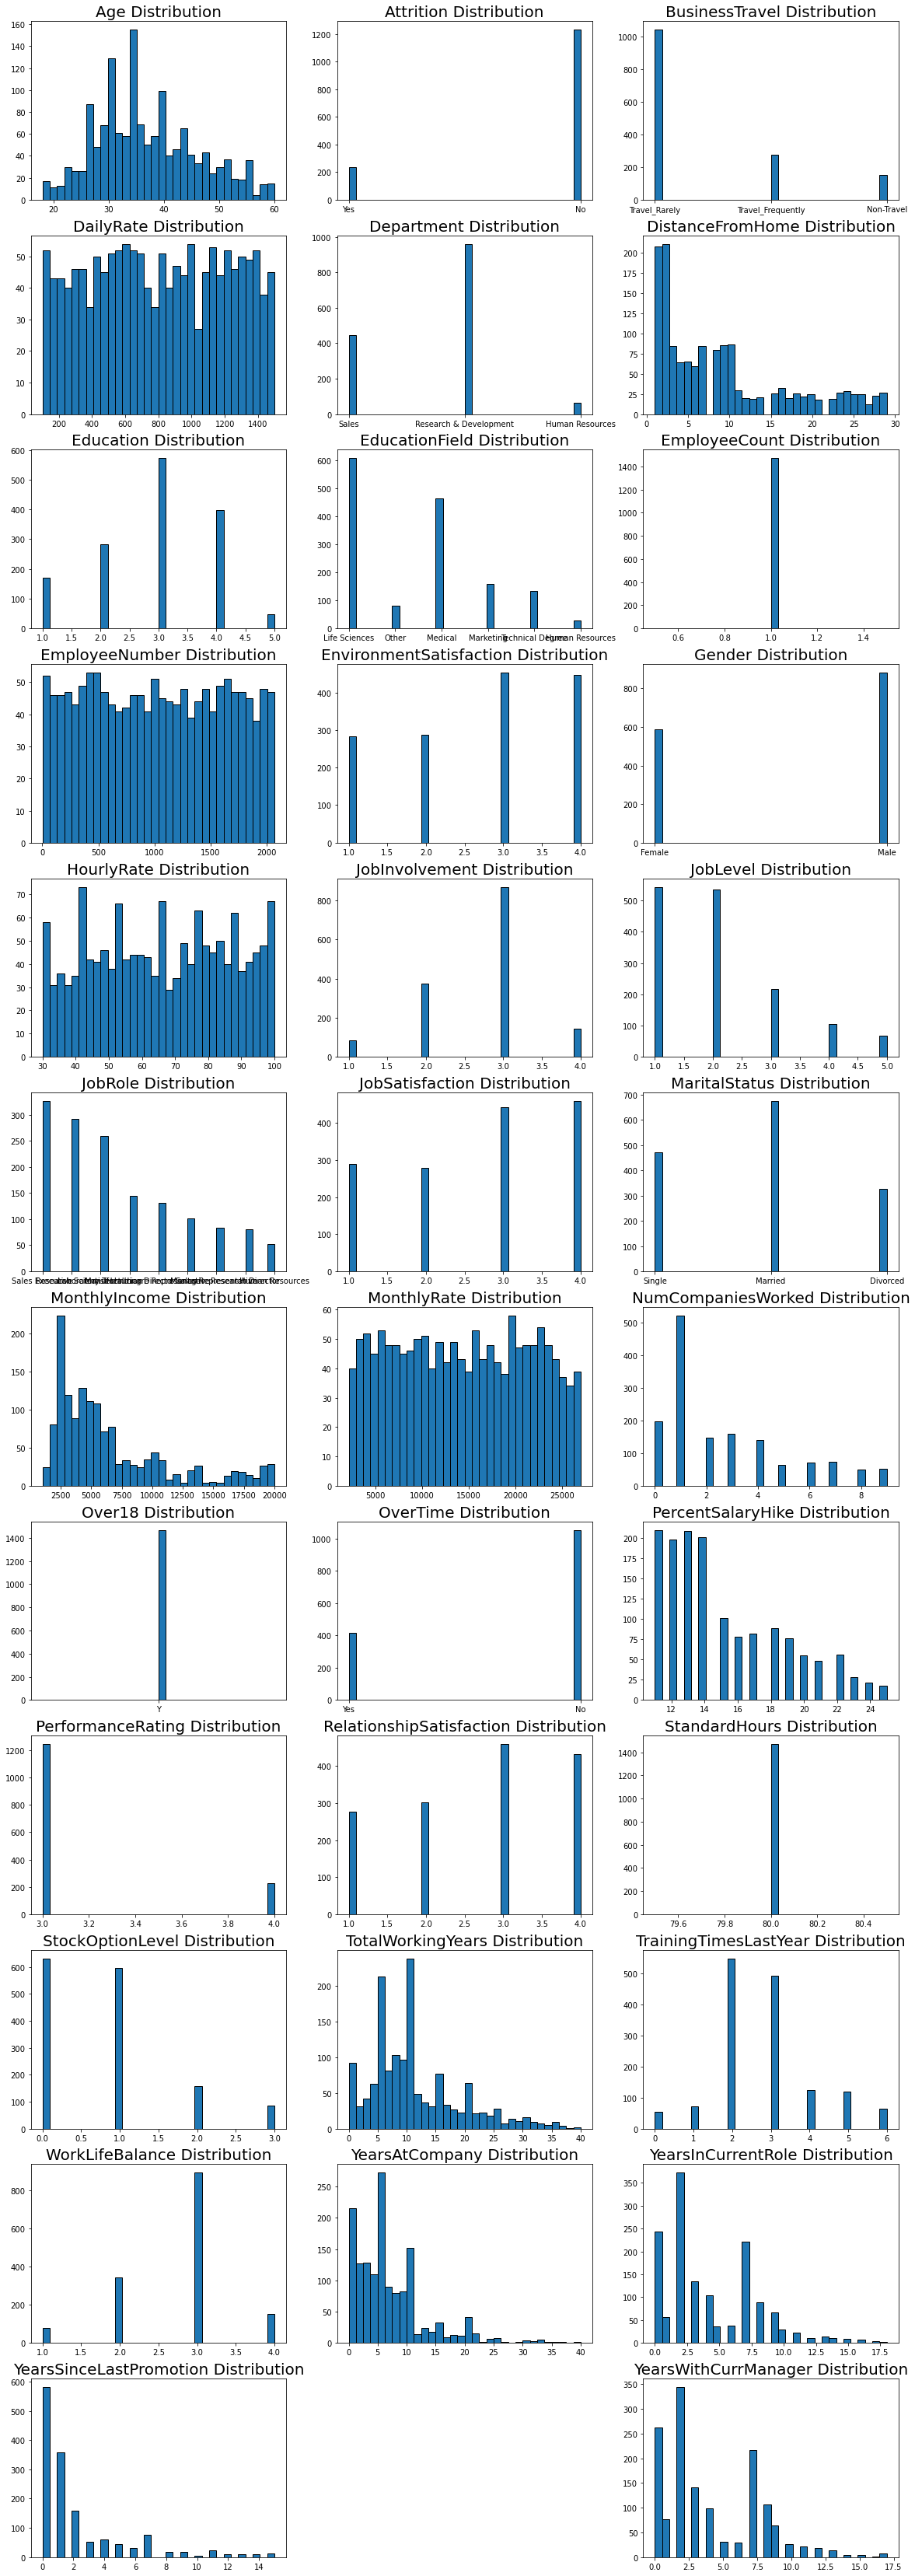

In [4]:
fig = plt.figure(figsize=(20, 60))
gs = gridspec.GridSpec(12,3)
for index, col in enumerate(list(df.columns)):
    index = index+1 if index == len(list(df.columns))-1 else index
    ax = plt.subplot(gs[index])
    ax.hist(df[col], bins=32, edgecolor='black')
    ax.set_title(col+" Distribution", fontdict={'fontsize':20})

In [5]:
# plt.figure(figsize=(16,12))
# sns.heatmap(df.corr(),annot=True,linewidths=2)

## Q2 - Model Training

### Data Spliting

In [6]:
df_attrition = df.pop("Attrition")
X_train, X_test, y_train, y_test = train_test_split(df, df_attrition, test_size=0.3, random_state=42)

### Linear Regression

In [7]:
# Removing unneeded columns
X_train_lr = X_train.drop(["BusinessTravel", "Department", "EducationField", "EmployeeNumber", "Gender", "JobRole", "MaritalStatus", "Over18", "OverTime"], axis=1)
# X_train_lr.columns
y_train_lr = y_train.map(dict(Yes=1, No=0))
# y_train_lr
lr = LinearRegression()
lr.fit(X_train_lr, y_train_lr)

LinearRegression()

In [9]:
X_test_lr = X_test.drop(["BusinessTravel", "Department", "EducationField", "EmployeeNumber", "Gender", "JobRole", "MaritalStatus", "Over18", "OverTime"], axis=1)
y_test_lr = y_test.map(dict(Yes=1, No=0))
predictions = lr.predict(X_test_lr)
print("Mean absolute error (MAE):", metrics.mean_absolute_error(y_test_lr,predictions))
print("Mean square error (MSE):", metrics.mean_squared_error(y_test_lr,predictions))
print("Root mean square error (RMSE):", np.sqrt(metrics.mean_squared_error(y_test_lr,predictions)))

Mean absolute error (MAE): 0.24407729003565856
Mean square error (MSE): 0.10981539271833819
Root mean square error (RMSE): 0.3313840562222905


### Logistic Regression

### Singular Vector

### Naive Bayes

### Decision Tree

### KNN

## Q3 - Model Testing